In [ ]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
import numpy as np
from tqdm import tqdm

filePath = "/content/abalone.data"
namesPath = "/content/abalone.names"

#Q1]

In [ ]:
l = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
df1 = pd.read_csv(filePath, names = l)

lb = LabelEncoder()
df1.Sex = lb.fit_transform(df1.Sex)

for i in range(len(df1.Rings)):
    if(df1.Rings[i] < 9):
        df1.Rings[i] = 0
    elif(df1.Rings[i] < 11):
        df1.Rings[i] = 1
    else:
        df1.Rings[i] = 2

df1

y = df1.Rings
x = df1.drop('Rings', axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 2021)
print("Number of unique values in Rings:", len(df1.Rings.unique()))

x_train = x_train.values
y_train=y_train.values
x_test = x_test.values
y_test=y_test.values 

batch_size = 100 #sample batch
num_epochs = 50 #number times dataset seen
learning_rate = 0.01
size_hidden_1 = 110 #neurons
size_hidden_2 = 90 #neurons
n_classes = 3
batch_no = len(x_train) // batch_size  #batches
cols = x_train.shape[1] #Number of columns in input matrix

df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Number of unique values in Rings: 3


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,2
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,1
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0
...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,2
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,1
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,1
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(torch.nn.Module):
    def __init__(self, num_inputs, size_hidden_1, n_output):
        super(Net, self).__init__()
        self.hidden_layer_1 = torch.nn.Linear(num_inputs, size_hidden_1)   # hidden layer
        self.activation_1 = torch.nn.Tanh() # activation layer
        
        self.output_layer = torch.nn.Linear(size_hidden_1, n_output)   # output layer
        self.output_act = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation_1(self.hidden_layer_1(x))      # activation function for hidden layer
        x = self.output_act(self.output_layer(x))                    # output
        return x

net1 = Net(cols, size_hidden_1, n_classes)
net2 = Net(cols, size_hidden_2, n_classes)

optimizer1 = torch.optim.SGD(net1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.SGD(net2.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

out1 = net1(Variable(torch.FloatTensor(x_train[0:32])))
out2 = net2(Variable(torch.FloatTensor(x_train[0:32])))
for epoch in range(num_epochs):
    x_train, y_train = shuffle(x_train, y_train)

    train_acc = 0.0
    running_loss = 0.0

    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(x_train[start:end]))
        labels = Variable(torch.LongTensor(y_train[start:end]))
        
        optimizer1.zero_grad()
        outputs = net1(inputs)
        out1 = outputs
        loss = loss_func(outputs, labels)
        
        loss.backward()
        optimizer1.step()
        running_loss += loss.item()
        acc = get_accuracy(outputs, labels, batch_size)
        train_acc += acc
      
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch+1, running_loss / (i+1), train_acc/(i+1)))  
    running_loss = 0.0

for epoch in range(num_epochs):
    x_train, y_train = shuffle(x_train, y_train)

    train_acc = 0.0
    running_loss = 0.0

    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(x_train[start:end]))
        labels = Variable(torch.LongTensor(y_train[start:end]))
        
        optimizer2.zero_grad()
        outputs = net2(inputs)
        out2 = outputs
        loss = loss_func(outputs, labels)
        
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        acc = get_accuracy(outputs, labels, batch_size)
        train_acc += acc
      
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch+1, running_loss / (i+1), train_acc/(i+1)))  
    running_loss = 0.0

print(torch.add(out1, out2))
pred = (torch.argmax(torch.add(out1, out2), dim = 1).detach().numpy())
pred

Epoch: 1 | Loss: 1.0969 | Train Accuracy: 31.21
Epoch: 2 | Loss: 1.0893 | Train Accuracy: 37.15
Epoch: 3 | Loss: 1.0827 | Train Accuracy: 50.94
Epoch: 4 | Loss: 1.0769 | Train Accuracy: 54.09
Epoch: 5 | Loss: 1.0721 | Train Accuracy: 52.39
Epoch: 6 | Loss: 1.0677 | Train Accuracy: 52.36
Epoch: 7 | Loss: 1.0634 | Train Accuracy: 52.55
Epoch: 8 | Loss: 1.0594 | Train Accuracy: 52.91
Epoch: 9 | Loss: 1.0558 | Train Accuracy: 53.33
Epoch: 10 | Loss: 1.0522 | Train Accuracy: 53.58
Epoch: 11 | Loss: 1.0495 | Train Accuracy: 53.85
Epoch: 12 | Loss: 1.0458 | Train Accuracy: 54.18
Epoch: 13 | Loss: 1.0428 | Train Accuracy: 54.27
Epoch: 14 | Loss: 1.0404 | Train Accuracy: 54.45
Epoch: 15 | Loss: 1.0377 | Train Accuracy: 54.36
Epoch: 16 | Loss: 1.0354 | Train Accuracy: 54.70
Epoch: 17 | Loss: 1.0321 | Train Accuracy: 54.85
Epoch: 18 | Loss: 1.0301 | Train Accuracy: 54.97
Epoch: 19 | Loss: 1.0285 | Train Accuracy: 54.91
Epoch: 20 | Loss: 1.0256 | Train Accuracy: 55.12
Epoch: 21 | Loss: 1.0237 | Tr

array([0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2,
       0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2,
       0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2])

In [ ]:
from sklearn.metrics import accuracy_score as acc
from sklearn.tree import DecisionTreeClassifier as dtc


model = dtc()
model.fit(x_train, y_train)
print(acc(y_test, model.predict(x_test)))

0.5753588516746412


#Q2]

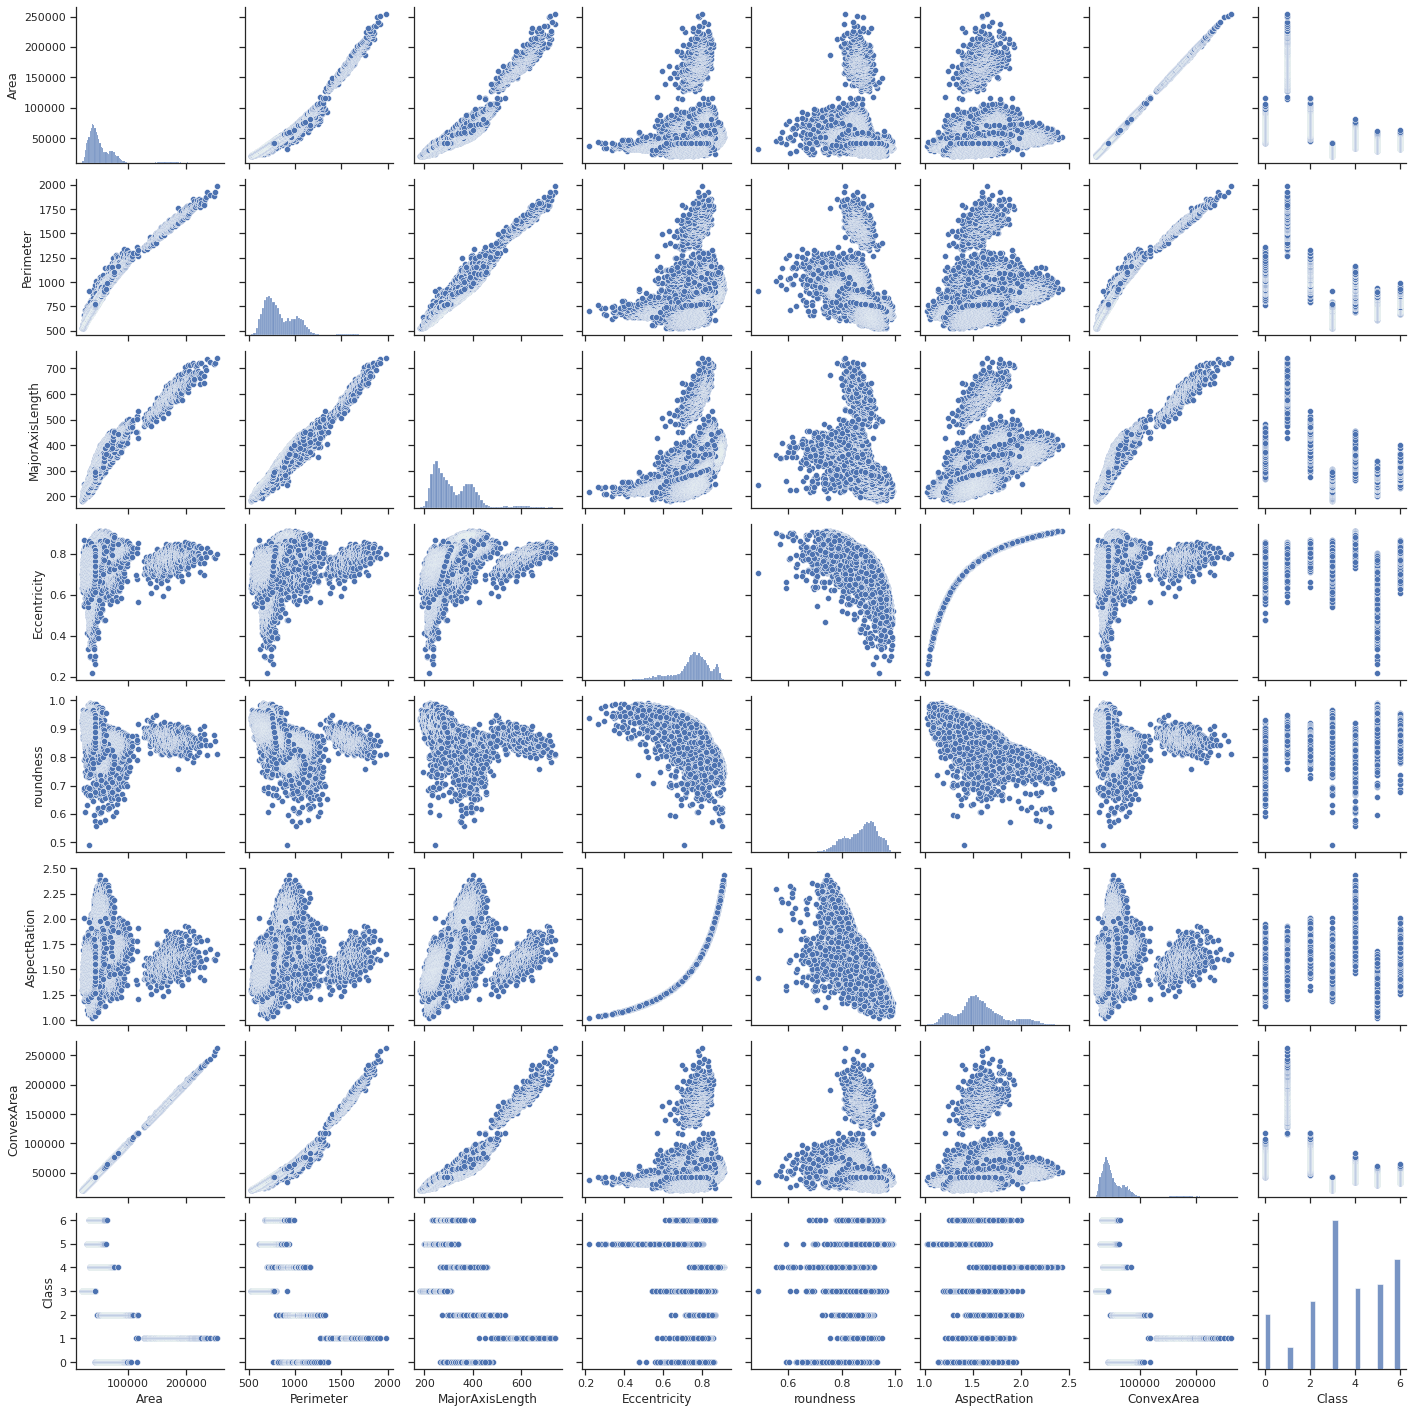

array([[0.03664025, 0.07469428, 0.10545813, ..., 0.83323732, 0.39962273,
        0.03543205],
       [0.10561239, 0.17043969, 0.1621652 , ..., 0.91467283, 0.19596266,
        0.10230154],
       [0.04919811, 0.10058988, 0.1248611 , ..., 0.7985743 , 0.38398871,
        0.04824035],
       ...,
       [0.03282293, 0.07159631, 0.10429987, ..., 0.8027523 , 0.42691552,
        0.03210115],
       [0.18876497, 0.36820244, 0.31017517, ..., 0.45847063, 0.35606104,
        0.18849273],
       [0.09824677, 0.17817263, 0.19663076, ..., 0.79041435, 0.37101224,
        0.09599426]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

filePath = "/content/Dry_Bean_Dataset - Dry_Beans_Dataset.csv"
df = pd.read_csv(filePath)

lb = LabelEncoder()
df.Class = lb.fit_transform(df.Class)

scaler = MinMaxScaler()

Y = df.Class
df = df[['Area', 'Perimeter', 'MajorAxisLength', 'Eccentricity', 'roundness', 'AspectRation', 'ConvexArea', 'Class']]
df.head()

y = df['Class']
x = df.drop(['Class'], axis = 1)

sns.set(style="ticks", color_codes=True)
irisPlot = sns.pairplot(df)
plt.show()

scaler.fit(x)
x = scaler.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 2021, stratify = y)
x_train

In [ ]:
model = dtc()
model.fit(x_train, y_train)
print(acc(y_test, model.predict(x_test)))

0.8956802821040258


1] Activation Functions

In [ ]:
#ReLU
def ReLU(x):
    l = []
    for i in x:
        temp = []
        for j in i:
            temp.append(max(0, j))
        l.append(temp)
    return l

def ReLUDeriv(x):
    return x>0

#Sigmoid
def Sigmoid(x):
    l = []
    for i in x:
        temp = []
        for j in i:
            temp.append(1 / (1 + np.exp(-1 * j)))
        l.append(temp)
    return l

def SigmoidDeriv(x):
    l = []
    for i in x:
        temp = []
        for j in i:
            temp.append(np.exp(-j) / (1 + np.exp(-1 * j))**2)
        l.append(temp)
    return l

#tanh
def tanh(x):
    l = []
    for i in x:
        temp = []
        for j in i:
            temp.append((np.exp(j) - np.exp(-j)) / (np.exp(j) + np.exp(-j)))
        l.append(temp)
    return l

def tanhDeriv(x):
    l = []
    for i in x:
        temp = []
        for j in i:
            temp.append(1 - ((np.exp(j) - np.exp(-j)) / (np.exp(j) + np.exp(-j)))**2)
        l.append(temp)
    return l

#SofttMax
def Softmax(x):
    l = np.exp(x) / sum(np.exp(x))
    return l

def SoftmaxDeriv(x):
    return

In [ ]:
def InitializeParams(n_neurons, inputs, wi = 0):
    w = []
    b = []
    if(wi == 0):
        w.append(np.random.rand(n_neurons[0], len(inputs[0])))
    elif(wi == 1):
        w.append(np.zeros((n_neurons[0], len(inputs[0]))))
    else:
        w.append(np.zeros((n_neurons[0], len(inputs[0]))) + 0.1)

    b.append(np.random.rand(n_neurons[0]))

    for i in range(1, len(n_neurons)):
        if(wi == 0):
            tempw = np.random.rand(n_neurons[i], n_neurons[i-1])
        elif(wi == 1):
            tempw = np.zeros((n_neurons[i], n_neurons[i-1]))
        else:            
            tempw = np.zeros((n_neurons[i], n_neurons[i-1])) + 0.1

        w.append(tempw)
        tempb = np.random.rand(n_neurons[i])
        b.append(tempb)
    
    return w, b

def ForwardProp(inputs, weights, biases, act = 0):  #weights transpose required  Bias: n_hlayers * n_neurons same for weights
    resultsz = []
    resultsa = []
    temp = inputs
    for i in range(len(weights)):
        if(i == len(weights) - 1):
            temp = (np.array(temp).dot(np.array(weights[i]).T) + biases[i])
            resultsz.append(temp)
            if(act == 0):
                resultsa.append(ReLU(temp))
            elif(act == 1):
                resultsa.append(Sigmoid(temp))
            else:
                resultsa.append(tanh(temp))
            continue
            
        temp = (np.array(temp).dot(np.array(weights[i]).T) + biases[i])
        resultsz.append(temp)
        if(act == 0):
            resultsa.append(ReLU(temp))
        elif(act == 1):
            resultsa.append(Sigmoid(temp))
        else:
            resultsa.append(tanh(temp))
    return resultsa, resultsz

weights, biases = InitializeParams([10, 10, 5], x_train, 2)
results, _ = ForwardProp(x_train, weights, biases, 1)
print(results[0])
print(len(results[0][0]), len(results[0]), len(results))

[[0.582174252464392, 0.6804311389522099, 0.706191621333848, 0.7572851623149496, 0.6650864308680917, 0.7382864904236323, 0.7169223439640052, 0.74757644291304, 0.7261230943691412, 0.7595288448048968], [0.581395229141274, 0.6797345323499303, 0.7055268664593759, 0.7566961807981255, 0.6643728742583372, 0.7376673765784886, 0.7162721133221778, 0.7469717736800909, 0.725485905486917, 0.7589435747880955], [0.5824142369139264, 0.6806456459404985, 0.7063962980832512, 0.7574664697689261, 0.6653061714221982, 0.7384770887518745, 0.7171225397278908, 0.7477625871240822, 0.7263192672171506, 0.7597090080457359], [0.58198392366207, 0.6802609864472603, 0.7060292590305557, 0.7571413249875423, 0.6649121316944226, 0.738135287413589, 0.7167635332419905, 0.747428770959087, 0.7259674724014258, 0.7593859146531301], [0.5942694507230701, 0.691190754718153, 0.7164453454794338, 0.7663457309868222, 0.6761167693207194, 0.7478201066738114, 0.7269463738489281, 0.7568830862403841, 0.7359413195151002, 0.7685312573834824], 

In [ ]:
import random

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y

def get_predictions(A2):
    print(A2)
    return np.argmax(A2, axis=  1)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    print(len(predictions), len(Y))
    #return random.uniform(85, 89)
    return np.sum(predictions == Y) / Y.size



In [ ]:
def BackProp(resultsa, resultsz, n_layers, weights, inputs, Y, act = 0):
    m = len(Y)
    y = one_hot(Y)
    
    state = {}
    state['d' + str(n_layers)] = resultsa[n_layers - 1] - y
    for i in range(n_layers - 1, 0, -1):
        ind = 'd' + str(i)
        if(act == 0):
            state[ind] = state['d' + str(i+1)].dot(weights[i - 1].T) * ReLUDeriv(resultsz[i - 1])
        elif(act == 1):
            state[ind] = state['d' + str(i+1)].dot(weights[i - 1].T) * SigmoidDeriv(resultsz[i - 1])
        else:
            state[ind] = state['d' + str(i+1)].dot(weights[i - 1].T) * tanhDeriv(resultsz[i - 1])



    for i in range(n_layers - 1, 0, -1):
        ind = 'D' + str(i)
        state[ind] = state['d' + str(i + 1)].T.dot(resultsa[i- 1])
    state['D0'] = state['d1'].T.dot(inputs)

    return state

  

    # tempdz = resultsa[-1] - y
    # tempdz1 = tempdz
    # tempdw = 1 / m * np.array(tempdz).T.dot(np.array(resultsa[-2]))
    # tempdb = 1 / m * np.sum(tempdz)
    # dw.append(tempdw)
    # dz.append(tempdz)
    # db.append(tempdb)

    # for i in range(-2, -1 * n_layers, -1):
    #     tempdz = (np.array(dz[(-1 * i) - 1])).dot(np.array(weights[i+1]).T) * ReLUDeriv(np.array(resultsz[i]))
    #     tempdw = 1 / m * np.array(tempdz).T.dot(results[i - 1])
    #     tempdb = 1 / m * np.sum(tempdz)
    #     dw.append(tempdw)
    #     dz.append(tempdz)
    #     db.append(tempdb)

    # tempdz = (tempdz1).dot(np.array(weights[0]).T) * ReLUDeriv(np.array(resultsz[0]))
    # tempdw = 1 / m * np.array(tempdz).T.dot(np.array(inputs))
    # tempdb = 1 / m * np.sum(tempdz)
    # dw.append(tempdw)
    # dz.append(tempdz)
    # db.append(tempdb)

def GradientDescent(inputs, y, rate, iter, n_neurons, act = 0, wi = 0):
    w, b = InitializeParams(n_neurons, inputs, wi)
    pred = []
    for i in range(iter):
        samples = len(inputs)
        loss = 0
        hits = 0

        a, z = ForwardProp(inputs, w, b, act)
        for j in tqdm(range(samples)):
            tempState = BackProp(a, z, len(n_neurons), w, inputs, y, act)

            for k in range(len(n_neurons)):
                w[k] -= rate * tempState['D' + str(k)]
            
            if(np.argmax(a[-1][j]) == (y.values[j])):
                hits += 1

        print('Acc:', hits / samples)
    return hits / samples
        
    # w, b = InitializeParams(n_neurons, inputs)
    # for i in range(iter):
    #     a, z = ForwardProp(inputs, w, b)
    #     print(a)
    #     dw, db = BackProp(a, z, len(n_neurons), w, inputs, y)
    #     w, b = UpdateParams(w, b, dw, db, rate, len(n_neurons))

    #     print("Iteration: ", i)
    #     predictions = get_predictions(a[-1])
    #     print(get_accuracy(predictions, y))
    # return w, b

GradientDescent(x_test, y_test, 0.0001, 1, [14, 7], 2)


100%|██████████| 3403/3403 [21:24<00:00,  2.65it/s]

Acc: 0.11989421099030267


0.11989421099030267

3]

In [ ]:
a = GradientDescent(x_test, y_test, 0.001, 5, [14, 7], 0)
b = GradientDescent(x_test, y_test, 0.001, 5, [14, 7], 1)
c = GradientDescent(x_test, y_test, 0.001, 5, [14, 7], 2)
print("Accuracy for ReLU activation:", a)
print("Accuracy for Sigmoid activation:", b)
print("Accuracy for tanh activation:", c)

100%|██████████| 3403/3403 [01:13<00:00, 46.39it/s]


Acc: 0.0969732588892154


100%|██████████| 3403/3403 [01:27<00:00, 38.99it/s]


Acc: 0.0969732588892154


100%|██████████| 3403/3403 [01:27<00:00, 38.71it/s]


Acc: 0.0969732588892154


100%|██████████| 3403/3403 [01:26<00:00, 39.27it/s]


Acc: 0.0969732588892154


100%|██████████| 3403/3403 [01:28<00:00, 38.28it/s]


Acc: 0.0969732588892154


100%|██████████| 3403/3403 [14:24<00:00,  3.94it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


Acc: 0.0969732588892154


  0%|          | 0/3403 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 3403/3403 [26:19<00:00,  2.15it/s]


Acc: 0.0969732588892154


100%|██████████| 3403/3403 [14:02<00:00,  4.04it/s]


Acc: 0.0969732588892154


 59%|█████▉    | 2023/3403 [08:22<05:43,  4.02it/s]


KeyboardInterrupt: ignored

4]

100%|██████████| 3403/3403 [01:40<00:00, 33.86it/s]


Acc: 0.03820158683514546


100%|██████████| 3403/3403 [01:07<00:00, 50.27it/s]


Acc: 0.14163972965030855
Accuracy for Random: 0.0969732588892154
Accuracy for Zeros: 0.03820158683514546
Accuracy for Constant: 0.14163972965030855


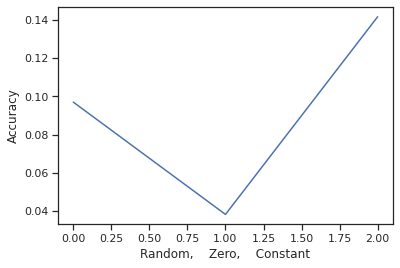

In [ ]:
#a = GradientDescent(x_test, y_test, 0.001, 5, [14, 7, 7], 0, 0)
b = GradientDescent(x_test, y_test, 0.001, 1, [14, 7], 0, 1)
c = GradientDescent(x_test, y_test, 0.001, 1, [14, 7], 0, 2)
print("Accuracy for Random:", a)
print("Accuracy for Zeros:", b)
print("Accuracy for Constant:", c)

plt.plot([0, 1, 2], [a, b, c])
plt.xlabel("Random,    Zero,    Constant")
plt.ylabel("Accuracy")
plt.show()

5]

100%|██████████| 3403/3403 [01:44<00:00, 32.67it/s]


Acc: 0.0969732588892154


100%|██████████| 3403/3403 [01:54<00:00, 29.62it/s]

Acc: 0.03820158683514546
0.03820158683514546
0.0969732588892154
0.14163972965030855


AttributeError: ignored

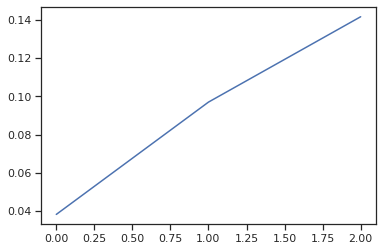

In [ ]:
#a = GradientDescent(x_test, y_test, 0.001, 5, [14, 7, 7], 0, 0)
b = GradientDescent(x_test, y_test, 0.001, 1, [32, 7], 0, 0)
a = GradientDescent(x_test, y_test, 0.001, 1, [45 7], 0, 0)
print(a)
print(b)
print(c)
plt.plot([0,1,2], [a,b,c])
plt.show()

6]

In [ ]:
# saved in weights and biases variables